# Football Match Data Analysis with Visualizations

## Load necessary library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Data Loading and Preparation

In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adamgbor/club-football-match-data-2000-2025")

print("Path to dataset files:", path)

Path to dataset files: /Users/mati/.cache/kagglehub/datasets/adamgbor/club-football-match-data-2000-2025/versions/3


In [10]:
df = pd.read_csv(
    '/Users/mati/.cache/kagglehub/datasets/adamgbor/club-football-match-data-2000-2025/versions/3/Matches.csv',
    low_memory=False
)


## Exploratory Data Analysis (EDA)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230557 entries, 0 to 230556
Data columns (total 48 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Division     230557 non-null  object 
 1   MatchDate    230557 non-null  object 
 2   MatchTime    99072 non-null   object 
 3   HomeTeam     230557 non-null  object 
 4   AwayTeam     230557 non-null  object 
 5   HomeElo      141597 non-null  float64
 6   AwayElo      141528 non-null  float64
 7   Form3Home    229057 non-null  float64
 8   Form5Home    229057 non-null  float64
 9   Form3Away    229057 non-null  float64
 10  Form5Away    229057 non-null  float64
 11  FTHome       230554 non-null  float64
 12  FTAway       230554 non-null  float64
 13  FTResult     230554 non-null  object 
 14  HTHome       175977 non-null  float64
 15  HTAway       175977 non-null  float64
 16  HTResult     175977 non-null  object 
 17  HomeShots    114735 non-null  float64
 18  AwayShots    114738 non-

### Convert MatchDate to datetime
- A season typically runs from August to May of the next year.
- We will define the season by the year the season ends.

In [36]:
df['MatchDate'] = pd.to_datetime(df['MatchDate'], errors='coerce')
df['Season'] = df['MatchDate'].apply(lambda x: x.year if x.month < 8 else x.year + 1)

### Add a column for TotalGoals (sum of home and away goals)

In [37]:
df['TotalGoals'] = df['FTHome'] + df['FTAway']

In [38]:
print(df.columns)

Index(['Division', 'MatchDate', 'MatchTime', 'HomeTeam', 'AwayTeam', 'HomeElo',
       'AwayElo', 'Form3Home', 'Form5Home', 'Form3Away', 'Form5Away', 'FTHome',
       'FTAway', 'FTResult', 'HTHome', 'HTAway', 'HTResult', 'HomeShots',
       'AwayShots', 'HomeTarget', 'AwayTarget', 'HomeFouls', 'AwayFouls',
       'HomeCorners', 'AwayCorners', 'HomeYellow', 'AwayYellow', 'HomeRed',
       'AwayRed', 'OddHome', 'OddDraw', 'OddAway', 'MaxHome', 'MaxDraw',
       'MaxAway', 'Over25', 'Under25', 'MaxOver25', 'MaxUnder25', 'HandiSize',
       'HandiHome', 'HandiAway', 'C_LTH', 'C_LTA', 'C_VHD', 'C_VAD', 'C_HTB',
       'C_PHB', 'TotalGoals', 'Season'],
      dtype='object')


### Define the top 5 leagues for focused analysis (division codes)
- E0 = Premier Leage
- SP1 = La Liga
- D1 = Bundesliga
- I1 = Seria A
- F1 = Ligue 1

In [31]:
top_5_leagues = ['E0', 'SP1', 'D1', 'I1', 'F1']

In [32]:
df_top5 = df[df['Division'].isin(top_5_leagues)].copy()

### Set plot style

In [33]:
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.family'] = 'Tahoma'

## 1. Evolution of the average number of goals per game
- How has the average number of goals per game changed over the seasons?
- This graph aims to show the trend in football playing styles over the period covered by the data, whether it's a trend towards more attacking play (higher average goals) or more defensive play (lower average goals), which may reflect overall tactical changes across various leagues.

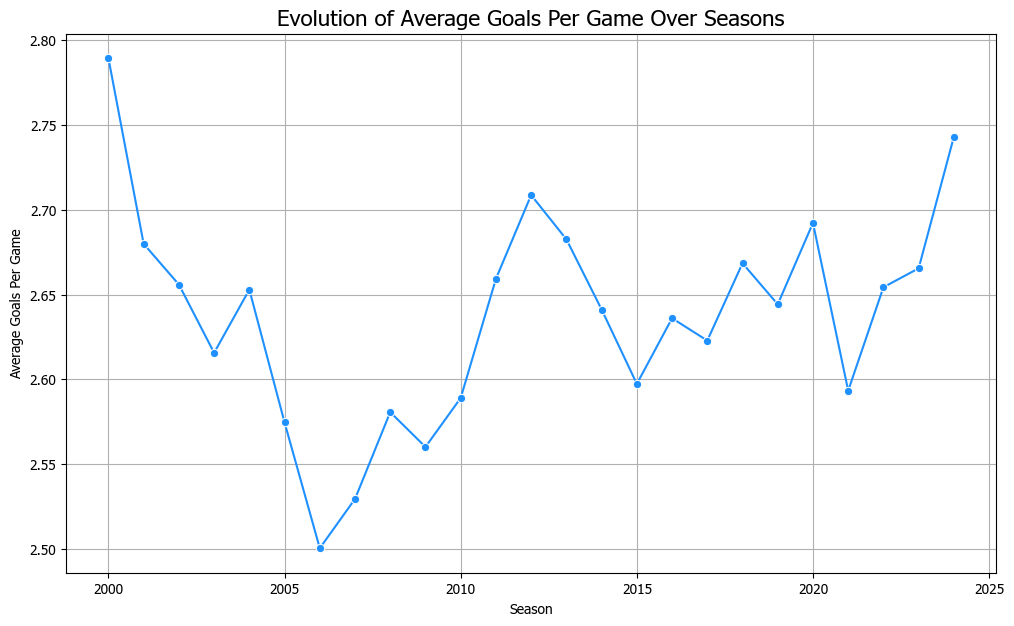

In [39]:
plt.figure()
avg_goals_season = df.groupby('Season')['TotalGoals'].mean().reset_index()
# Filter out data from the latest year which may be incomplete
avg_goals_season = avg_goals_season[avg_goals_season['Season'] < 2025]
sns.lineplot(data=avg_goals_season, x='Season', y='TotalGoals', marker='o', color='dodgerblue')
plt.title('Evolution of Average Goals Per Game Over Seasons', fontsize=16)
plt.xlabel('Season')
plt.ylabel('Average Goals Per Game')
plt.grid(True)
plt.savefig('1_avg_goals_per_season.png')
plt.show()

## 2. Leagues with the highest average number of goals
- Which league has the highest average number of goals per game?
- To identify the leagues that are likely to provide the most entertainment for fans who enjoy high-scoring games. This graph compares different leagues and helps pinpoint those with open gameplay and a tendency for more goals.

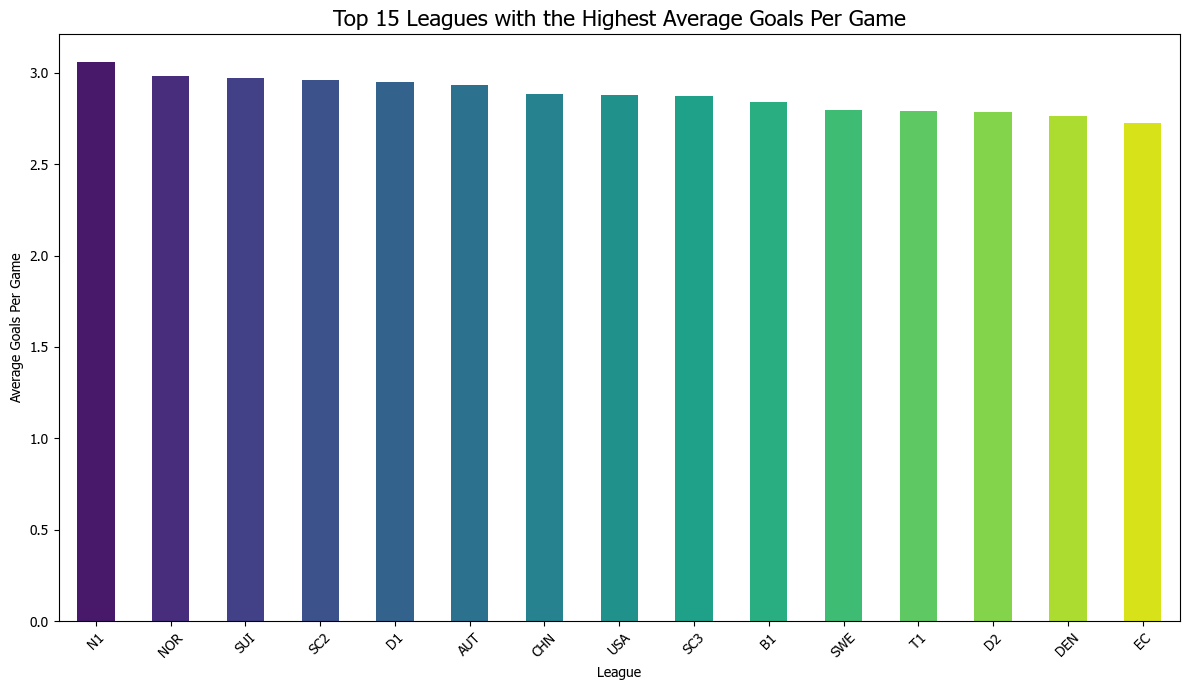

In [40]:
plt.figure()
# Calculate the average goals for leagues with a sufficient number of matches
leagues_to_analyze = df['Division'].value_counts()[df['Division'].value_counts() > 1000].index
df_filtered_leagues = df[df['Division'].isin(leagues_to_analyze)].copy()
avg_goals_league = df_filtered_leagues.groupby('Division')['TotalGoals'].mean().sort_values(ascending=False).head(15)
avg_goals_league.plot(kind='bar', color=sns.color_palette("viridis", 15))
plt.title('Top 15 Leagues with the Highest Average Goals Per Game', fontsize=16)
plt.xlabel('League')
plt.ylabel('Average Goals Per Game')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('2_avg_goals_by_league.png')
plt.show()

## 3. Proportion of match results in the 5 major league
- What is the distribution of match results (home win, draw, away win) in the top 5 European leagues?
- This graph aims to explore and compare the home-field advantage in top-tier leagues. Displaying the data as percentages provides a clear picture of which leagues have a particularly strong home team performance, or in which leagues playing away is not a significant disadvantage.

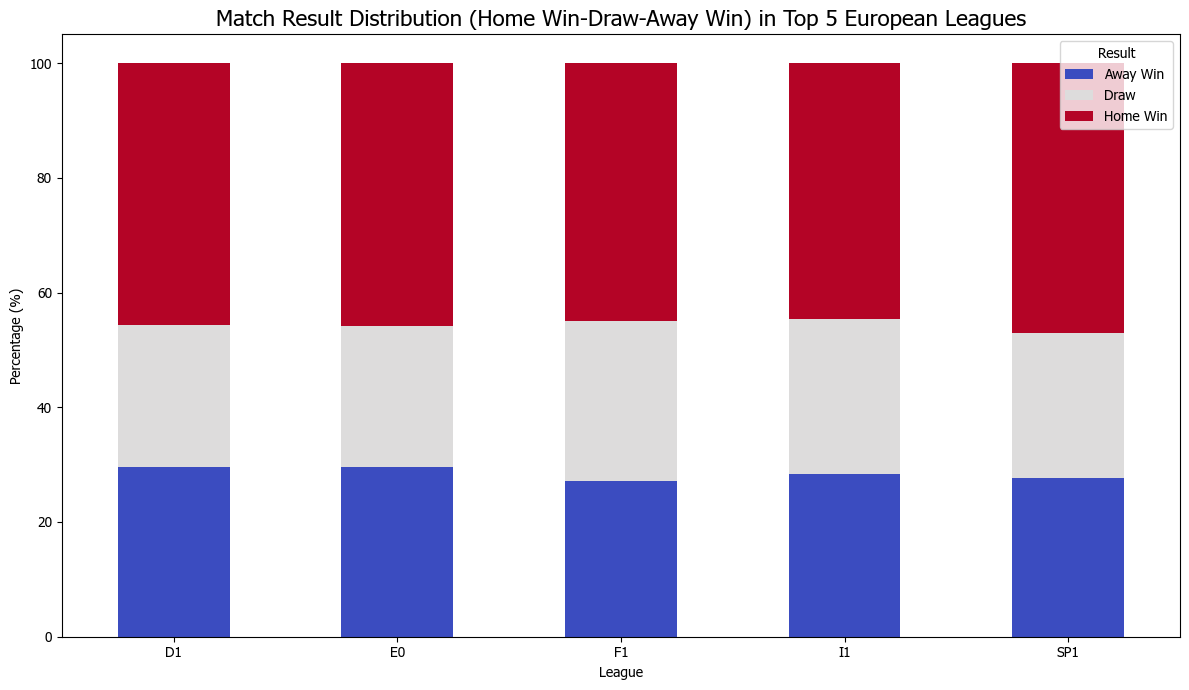

In [41]:
outcome_counts = df_top5.groupby(['Division', 'FTResult']).size().unstack(fill_value=0)
outcome_percentages = outcome_counts.div(outcome_counts.sum(axis=1), axis=0) * 100
outcome_percentages.plot(kind='bar', stacked=True, colormap='coolwarm')
plt.title('Match Result Distribution (Home Win-Draw-Away Win) in Top 5 European Leagues', fontsize=16)
plt.xlabel('League')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.legend(title='Result', labels=['Away Win', 'Draw', 'Home Win'])
plt.tight_layout()
plt.savefig('3_outcome_distribution_top5.png')
plt.show()


## 4. Relationship between Elo rating and number of goals scored
- Is there a relationship between a team's Elo rating and the number of goals they score?
- To test the hypothesis that teams with a higher Elo rating (a measure of team ability) have better attacking capabilities and score more goals. A scatter plot with a regression line helps to show the direction and strength of this relationship.

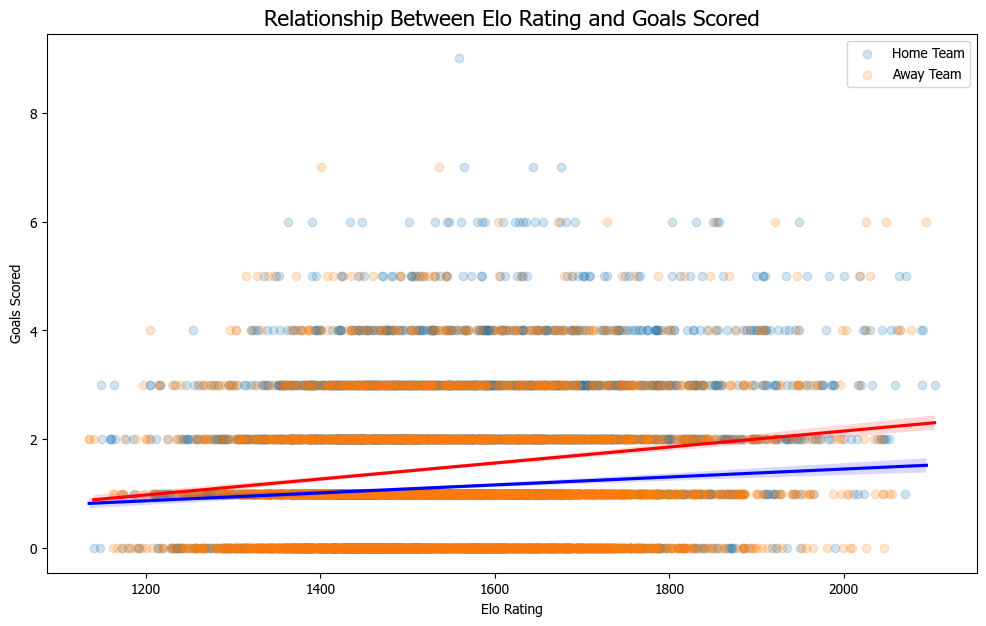

In [42]:
# To avoid plotting overly dense data, we will use a sample.
df_sample_elo = df.dropna(subset=['HomeElo', 'AwayElo', 'FTHome', 'FTAway']).sample(n=5000, random_state=1)
sns.regplot(data=df_sample_elo, x='HomeElo', y='FTHome',
            scatter_kws={'alpha':0.2}, line_kws={'color':'red'}, label='Home Team')
sns.regplot(data=df_sample_elo, x='AwayElo', y='FTAway',
            scatter_kws={'alpha':0.2}, line_kws={'color':'blue'}, label='Away Team')
plt.title('Relationship Between Elo Rating and Goals Scored', fontsize=16)
plt.xlabel('Elo Rating')
plt.ylabel('Goals Scored')
plt.legend()
plt.savefig('4_elo_vs_goals.png')
plt.show()

## 5. Relationship between shots, shots on target, and goals
- How do the number of shots and shots on target relate to the number of goals scored?
- To explore the efficiency of converting chances into goals. This bubble chart shows that it's not just about creating many shots, but the quality of the shots (shots on target) is crucial for scoring. The size of the circle represents the number of goals, illustrating that more shots on target often lead to more goals.

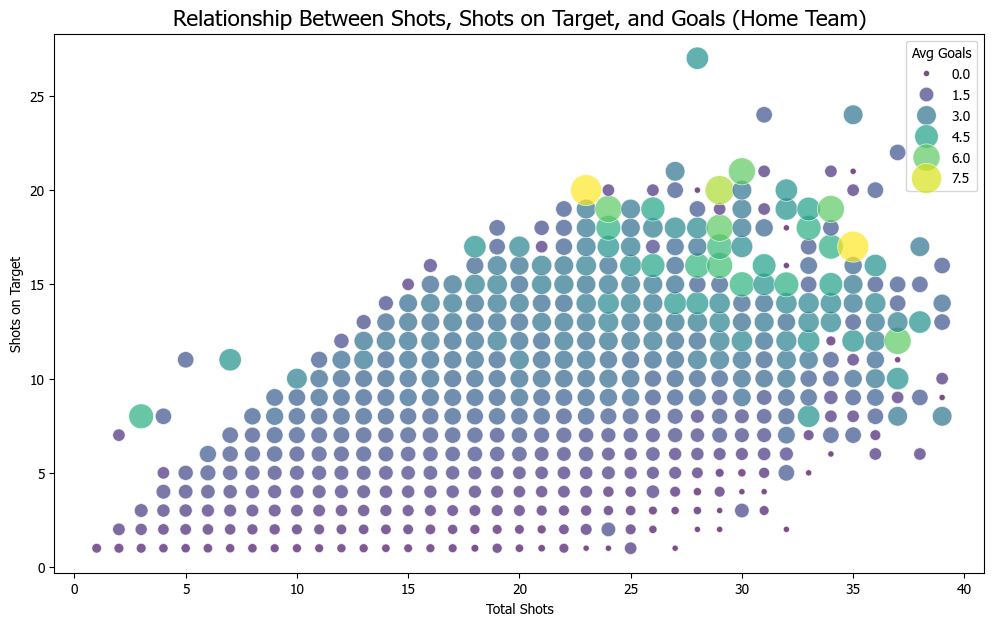

In [43]:
plt.figure()
# Use a bubble chart where the size of the circle represents the number of goals.
# Filter the data to make the plot clearer.
df_shots_filtered = df[(df['HomeShots'] > 0) & (df['HomeTarget'] > 0) & (df['HomeShots'] < 40)].copy()
df_shots_agg = df_shots_filtered.groupby(['HomeShots', 'HomeTarget'])['FTHome'].mean().reset_index()

sns.scatterplot(data=df_shots_agg, x='HomeShots', y='HomeTarget', size='FTHome',
                hue='FTHome', sizes=(20, 500), palette='viridis', alpha=0.7)
plt.title('Relationship Between Shots, Shots on Target, and Goals (Home Team)', fontsize=16)
plt.xlabel('Total Shots')
plt.ylabel('Shots on Target')
plt.legend(title='Avg Goals')
plt.savefig('5_shots_vs_goals.png')
plt.show()

## 6. Relationship between fouls and yellow cards
- Is there a relationship between committing fouls and receiving yellow cards?
- To see if committing fouls frequently leads to more yellow cards. This graph can reflect the strictness of referees or the aggressive playstyle of teams. A hexbin plot is suitable for large datasets to show the density of data points.

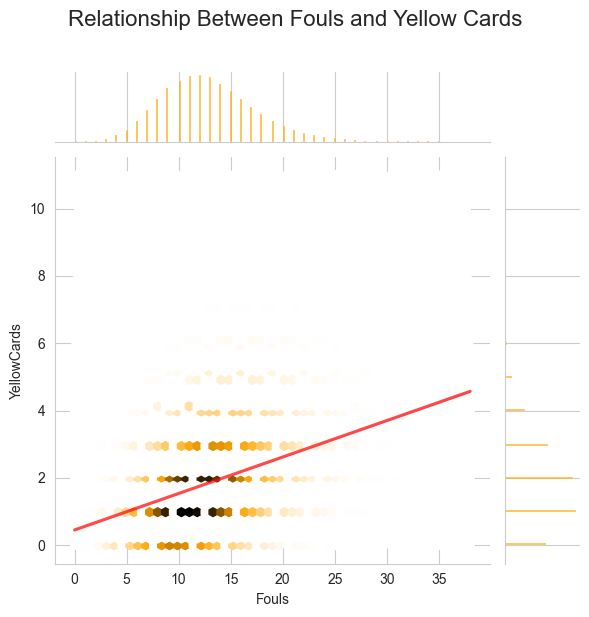

In [51]:
fouls = pd.concat([df['HomeFouls'], df['AwayFouls']]).rename('Fouls')
yellow_cards = pd.concat([df['HomeYellow'], df['AwayYellow']]).rename('YellowCards')
cards_df = pd.concat([fouls, yellow_cards], axis=1).dropna()
# Filter outliers to make the visualization clearer.
cards_df = cards_df[cards_df['Fouls'] < 40] 

g = sns.jointplot(
    data=cards_df,
    x='Fouls',
    y='YellowCards',
    kind='hex',
    color='#FFA500',   
    marginal_kws={'color': '#FFA500', 'alpha': 0.7} 
)

# เพิ่มเส้น regression และค่า correlation
g.plot_joint(sns.regplot, scatter=False, color='red', line_kws={'alpha': 0.7})
plt.suptitle('Relationship Between Fouls and Yellow Cards', y=1.02, fontsize=16)
plt.tight_layout()
plt.savefig('6_fouls_vs_yellow_cards.png')
plt.show()

## 7. Impact of form on match results
- How does a team's recent form (points from the last 5 matches) affect the match outcome?
- To analyze whether recent past performance is a good indicator of future results. This box plot shows the distribution of the "form difference" for each outcome, helping to see if teams with better form (positive Form5Difference) tend to win matches.

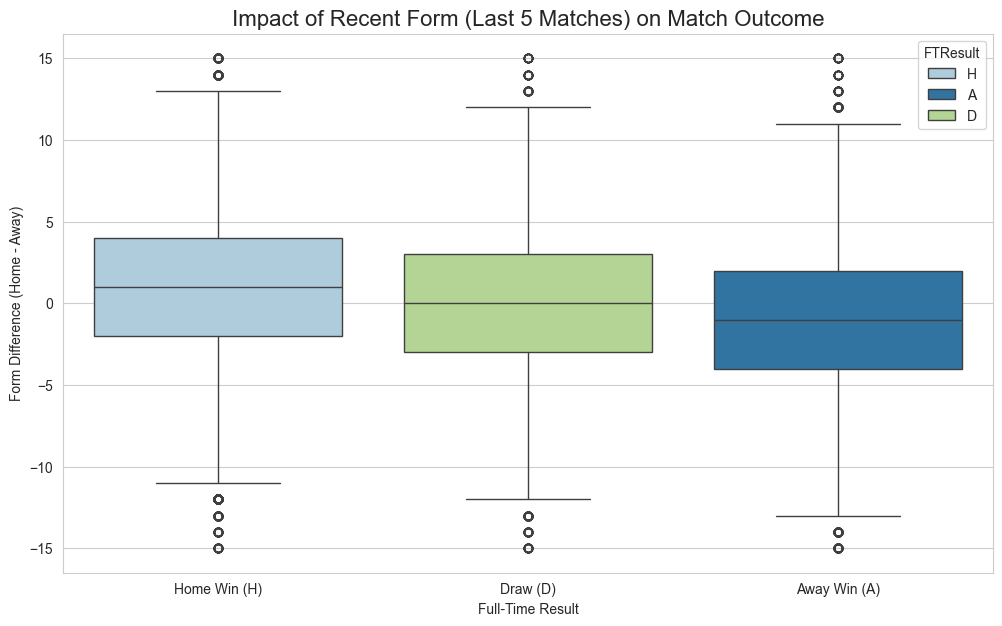

In [54]:
# Create the 'Form5Difference' feature as recommended in the dataset details.
df['Form5Difference'] = df['Form5Home'] - df['Form5Away']
plt.figure()
sns.boxplot(data=df, x='FTResult', y='Form5Difference', order=['H', 'D', 'A'], palette='Paired',
           hue='FTResult')
plt.title('Impact of Recent Form (Last 5 Matches) on Match Outcome', fontsize=16)
plt.xlabel('Full-Time Result')
plt.ylabel('Form Difference (Home - Away)')
plt.xticks([0, 1, 2], ['Home Win (H)', 'Draw (D)', 'Away Win (A)'])
plt.savefig('7_form_vs_outcome.png')
plt.show()

## 8. Distribution of goals between home and away teams
- What is the distribution of goals scored by home teams compared to away teams?
- To quantify the home-field advantage in terms of goal-scoring ability. This KDE plot compares the distribution of goals scored by home and away teams, making it clear whether home teams generally score more goals than away teams, and to what extent.

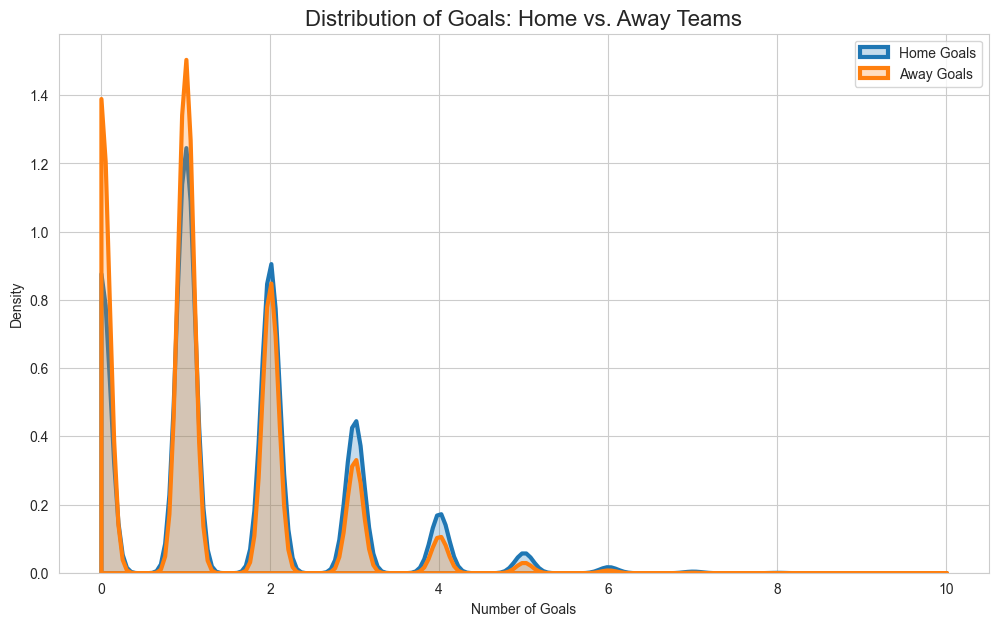

In [55]:
plt.figure()
sns.kdeplot(df['FTHome'], fill=True, label='Home Goals', clip=(0,10), lw=3)
sns.kdeplot(df['FTAway'], fill=True, label='Away Goals', clip=(0,10), lw=3)
plt.title('Distribution of Goals: Home vs. Away Teams', fontsize=16)
plt.xlabel('Number of Goals')
plt.ylabel('Density')
plt.legend()
plt.savefig('8_home_vs_away_goals_dist.png')
plt.show()


## 9. Betting odds versus actual results
- How well do betting odds align with actual outcomes?
- To assess the predictive accuracy of the betting market. This graph compares the "implied probability" (calculated from odds) with the "actual win rate." If the data points align closely with the diagonal red line, it indicates that the betting market predicts outcomes quite accurately.

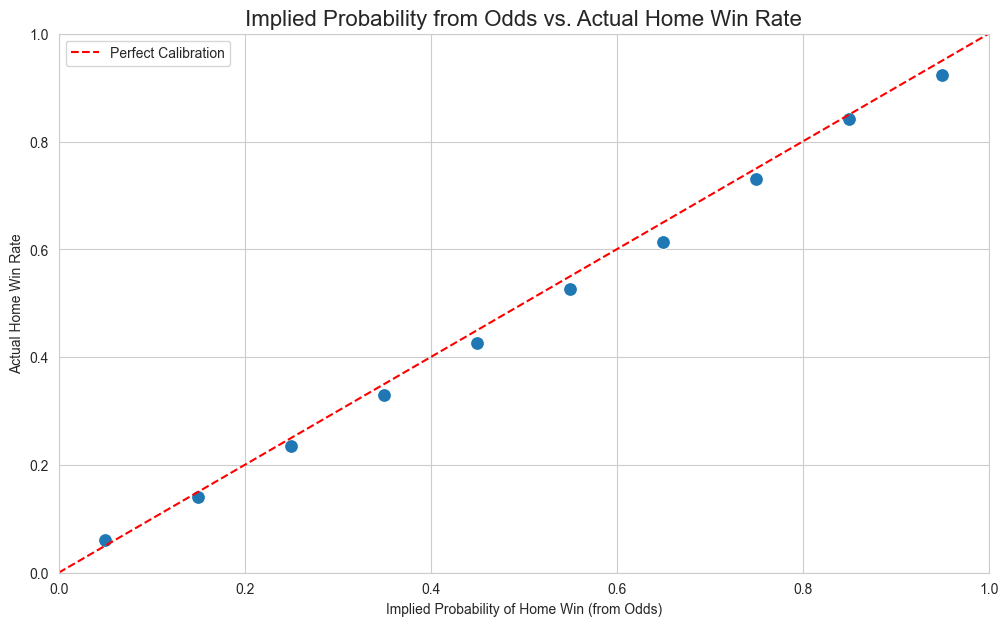

In [57]:
df_odds = df[['OddHome', 'FTResult']].dropna().copy()
df_odds['ImpliedProbHome'] = 1 / df_odds['OddHome']
# Group the probabilities to make the visualization clearer.
df_odds['ProbBin'] = pd.cut(df_odds['ImpliedProbHome'], bins=np.arange(0, 1.1, 0.1))
# Calculate the actual win rate in each group.
actual_win_rate = df_odds.groupby('ProbBin', observed=False)['FTResult'].apply(lambda x: (x == 'H').mean()).reset_index()
actual_win_rate.rename(columns={'FTResult': 'ActualHomeWinRate'}, inplace=True)
actual_win_rate['ProbBinCenter'] = actual_win_rate['ProbBin'].apply(lambda x: x.mid)

plt.figure()
sns.scatterplot(data=actual_win_rate, x='ProbBinCenter', y='ActualHomeWinRate', s=100)
# Calibration line
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Perfect Calibration') 
plt.title('Implied Probability from Odds vs. Actual Home Win Rate', fontsize=16)
plt.xlabel('Implied Probability of Home Win (from Odds)')
plt.ylabel('Actual Home Win Rate')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.savefig('9_odds_vs_reality.png')
plt.show()



## 10. Average number of corners versus average goals
- In each league, is there a relationship between the average number of corners per game and the average number of goals per game?
- To explore the relationship between set-piece opportunities (corners) and overall goal scoring in different leagues. This graph can help answer whether leagues that emphasize wing play and win many corners also tend to be high-scoring leagues. Each point on the graph represents one league.

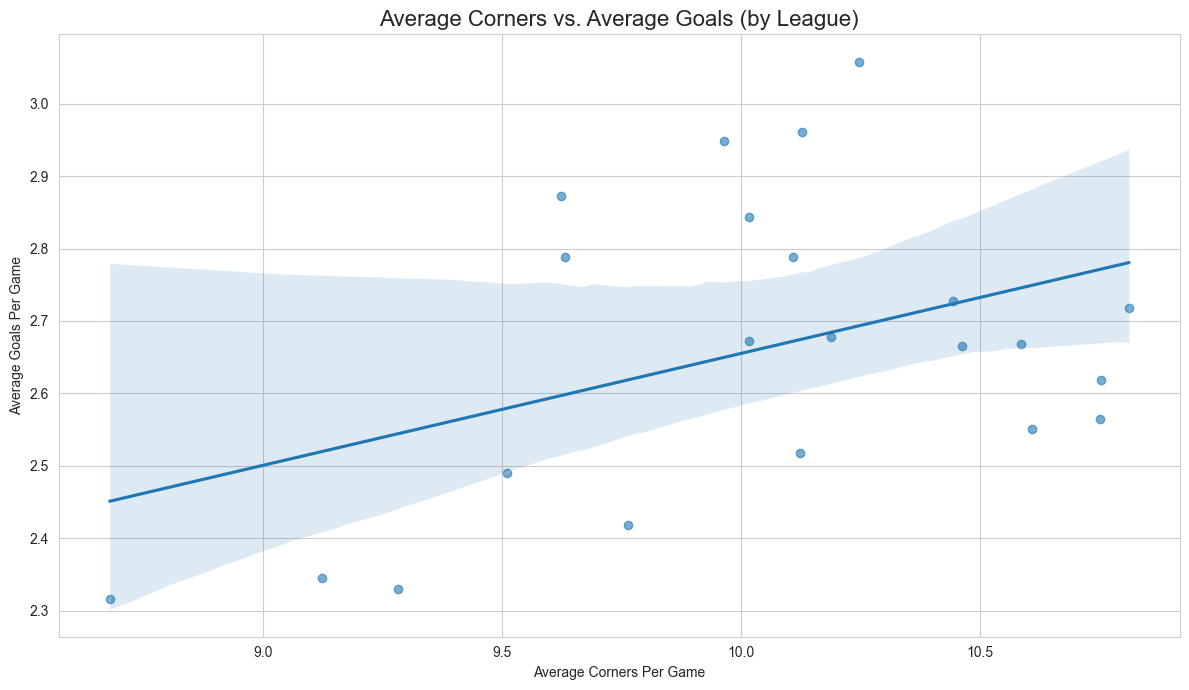

In [58]:
df['TotalCorners'] = df['HomeCorners'] + df['AwayCorners']
league_stats = df.groupby('Division').agg(
    AvgGoals=('TotalGoals', 'mean'),
    AvgCorners=('TotalCorners', 'mean'),
    MatchCount=('Division', 'size')
).reset_index()
# Filter for leagues with a large number of matches
league_stats_filtered = league_stats[league_stats['MatchCount'] > 1000]

plt.figure()
sns.regplot(data=league_stats_filtered, x='AvgCorners', y='AvgGoals',
            scatter_kws={'alpha': 0.6})
plt.title('Average Corners vs. Average Goals (by League)', fontsize=16)
plt.xlabel('Average Corners Per Game')
plt.ylabel('Average Goals Per Game')
plt.grid(True)
plt.tight_layout()
plt.savefig('10_corners_vs_goals_by_league.png')
plt.show()